In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
df = pd.read_csv('hybrid.csv')
df.head()

,time,pv_current1,pv_current2,pv_current3,pv_current4,pv_total_current,wind_turbine_current,inverter_current,ac_output_current,pv_input_voltage,dc_bus_voltage,ac_output_voltage,h2_pressure,pv1_temperature,pv2_temperature,pv3_temperature,battery_bank_temperature
0,12:00:00 AM,1.767853,1.863484,1.741650,1.775363,5.415713,26.612404,29.556963,3.697929,20.990072,5.312572,235.819992,72.357712,25.035004,24.754852,25.595306,23.105042
1,12:00:01 AM,1.768020,1.863317,1.741650,1.775363,5.425227,26.624926,29.604530,3.708610,21.175329,5.313572,235.810974,72.357712,25.003876,24.817108,25.564178,23.167297
2,12:00:02 AM,1.768354,1.863651,1.742318,1.775196,5.436742,26.617416,29.634575,3.708610,21.326534,5.313572,235.810974,72.352379,25.003876,24.754852,25.501923,23.167297
3,12:00:03 AM,1.768354,1.863317,1.741984,1.775363,5.419719,26.612404,29.622053,3.708610,21.587395,5.312572,235.797455,72.341690,24.941620,24.723724,25.408539,23.105042
4,12:00:04 AM,1.768354,1.863317,1.741817,1.775363,5.412710,26.624926,29.629562,3.709278,21.829226,5.312572,235.806473,72.347038,25.003876,24.692596,25.377411,23.167297


In [3]:
df.index = pd.to_datetime(df['time'])
df.index

DatetimeIndex(['2022-01-25 00:00:00', '2022-01-25 00:00:01',
               '2022-01-25 00:00:02', '2022-01-25 00:00:03',
               '2022-01-25 00:00:04', '2022-01-25 00:00:05',
               '2022-01-25 00:00:06', '2022-01-25 00:00:07',
               '2022-01-25 00:00:08', '2022-01-25 00:00:09',
               ...
               '2022-01-25 04:46:24', '2022-01-25 04:46:25',
               '2022-01-25 04:46:26', '2022-01-25 04:46:27',
               '2022-01-25 04:46:28', '2022-01-25 04:46:29',
               '2022-01-25 04:46:30', '2022-01-25 04:46:31',
               '2022-01-25 04:46:32', '2022-01-25 04:46:33'],
              dtype='datetime64[ns]', name='time', length=17194, freq=None)

<AxesSubplot:xlabel='time'>

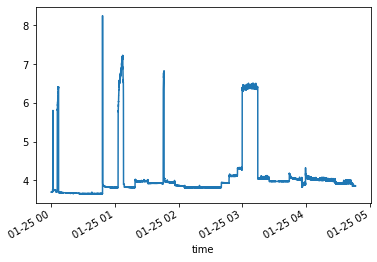

In [4]:
ac_out = df['ac_output_current']
ac_out.plot()

In [5]:
ac_out_df = pd.DataFrame({'AC Output Current (A)':ac_out})

In [6]:
ac_out_df['AC Output Voltage (V)'] = df['ac_output_voltage']
ac_out_df.head()

,AC Output Current (A),AC Output Voltage (V)
time,,
2022-01-25 00:00:00,3.697929,235.819992
2022-01-25 00:00:01,3.708610,235.810974
2022-01-25 00:00:02,3.708610,235.810974
2022-01-25 00:00:03,3.708610,235.797455
2022-01-25 00:00:04,3.709278,235.806473


In [7]:
values = ac_out_df.values

In [8]:
ac_out_df['AC Output Power (W)'] = (values[:,0]*values[:,1])
ac_out_df.head()

,AC Output Current (A),AC Output Voltage (V),AC Output Power (W)
time,,,
2022-01-25 00:00:00,3.697929,235.819992,872.045587
2022-01-25 00:00:01,3.708610,235.810974,874.530936
2022-01-25 00:00:02,3.708610,235.810974,874.530936
2022-01-25 00:00:03,3.708610,235.797455,874.480800
2022-01-25 00:00:04,3.709278,235.806473,874.671763


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

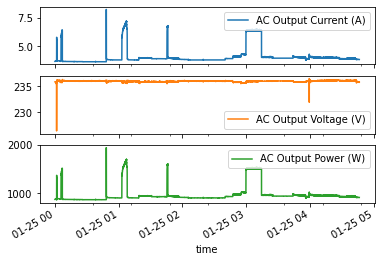

In [10]:
ac_out_df[['AC Output Current (A)', 'AC Output Voltage (V)', 'AC Output Power (W)']].plot(subplots=True)

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(ac_out_df)
dataset_df = pd.DataFrame(dataset, columns = ['AC Output Currnt (A)', 'AC Output Voltage (V)', 'AC Output Power (W)'])
dataset_df.head()

,AC Output Currnt (A),AC Output Voltage (V),AC Output Power (W)
0,0.008862,0.935183,0.014036
1,0.011186,0.934288,0.016318
2,0.011186,0.934288,0.016318
3,0.011186,0.932947,0.016272
4,0.011332,0.933841,0.016448


In [13]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row  = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1],df_as_np[i+window_size][2]]
        y.append(label)
    return np.array(X), np.array(y)

In [14]:
X, y = df_to_X_y(dataset_df)
X.shape, y.shape
#X(features,window_size,inputs) y(features,outputs)
#X(features,time_steps,samples)

((17189, 5, 3), (17189, 3))

In [15]:
X_train, y_train = X[:13000], y[:13000]
X_val, y_val = X[13000:15000], y[13000:15000]
X_test, y_test = X[15000:], y[15000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((13000, 5, 3), (13000, 3), (2000, 5, 3), (2000, 3), (2189, 5, 3), (2189, 3))

In [16]:
model1 = Sequential()
model1.add(InputLayer((5, 3))) #input layer is (window size, ouput value)
model1.add(LSTM(32, return_sequences=True))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(3, 'linear')) #last dense value is equal to output value
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 29,987
Trainable params: 29,987
Non-trainable params: 0
_________________________________________________________________


In [17]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [18]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size = 5, callbacks=[cp1])

Epoch 1/20
2598/2600 [============================>.] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.1302WARNING:tensorflow:From C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model1\assets
2600/2600 [==============================] - 37s 14ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 5.7387e-05 - val_root_mean_squared_error: 0.0076
Epoch 2/20
2600/2600 [==============================] - 11s 4ms/step - loss: 4.6978e-04 - root_mean_squared_error: 0.0217 - val_loss: 2.4050e-04 - val_root_mean_squared_error: 0.0155
Epoch 3/20
2

In [19]:
predictions = model1.predict(X)

In [20]:
predictions.shape

(17189, 3)

In [21]:
predictions_inv = scaler.inverse_transform(predictions)

In [22]:
predictions_df = pd.DataFrame(predictions_inv, columns = ['AC Output Current Predicted (A)', 'AC Output Voltage Predicted (V)', 'AC Output Power Predicted (W)'])
predictions_df

,AC Output Current Predicted (A),AC Output Voltage Predicted (V),AC Output Power Predicted (W)
0,3.717058,235.830933,873.682007
1,3.716848,235.827805,873.649658
2,3.716756,235.826874,873.623047
3,3.716868,235.826096,873.639343
4,3.716801,235.829086,873.647339
...,...,...,...
17184,3.863189,235.782654,908.859497
17185,3.864480,235.784668,909.068848
17186,3.866082,235.782700,909.397095
17187,3.868271,235.779327,909.867188


In [23]:
predictions_df.index = pd.to_datetime(df['time'][0:17189])

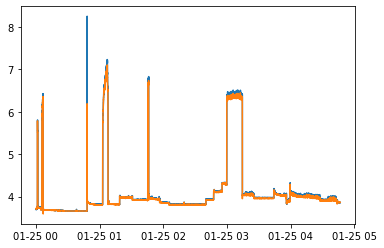

In [26]:
plt.plot(df['ac_output_current'])
plt.plot(predictions_df['AC Output Current Predicted (A)'])


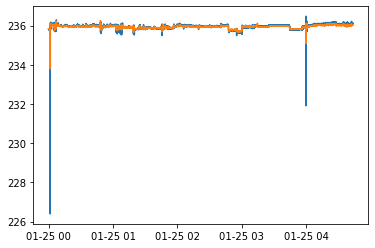

In [43]:
start,end = 0, 17000
plt.plot(df['ac_output_voltage'][start:end])
plt.plot(predictions_df['AC Output Voltage Predicted (V)'][start:end])

Text(0.5, 1.0, "AC Output Power's Forecast samples, (0-17000)")

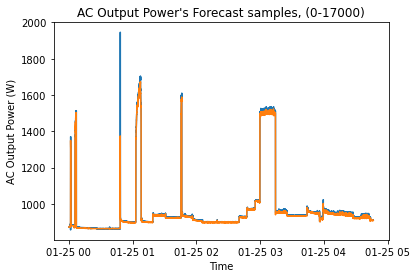

In [45]:
plt.plot(ac_out_df['AC Output Power (W)'])
plt.plot(predictions_df['AC Output Power Predicted (W)'])
plt.ylabel('AC Output Power (W)')
plt.xlabel('Time')
plt.title("AC Output Power's Forecast samples, (0-17000)")

Text(0.5, 1.0, "AC Output Power's Forecast samples, scaled 0-500")

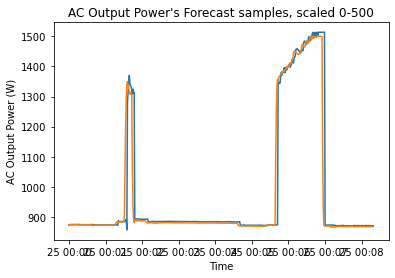

In [44]:
start, end = 0,500
plt.plot(ac_out_df['AC Output Power (W)'][start:end])
plt.plot(predictions_df['AC Output Power Predicted (W)'][start:end])
plt.ylabel('AC Output Power (W)')
plt.xlabel('Time')
plt.title("AC Output Power's Forecast samples, scaled 0-500")

In [31]:
predictions_df

,AC Output Current Predicted (A),AC Output Voltage Predicted (V),AC Output Power Predicted (W)
time,,,
2022-01-25 00:00:00,3.717058,235.830933,873.682007
2022-01-25 00:00:01,3.716848,235.827805,873.649658
2022-01-25 00:00:02,3.716756,235.826874,873.623047
2022-01-25 00:00:03,3.716868,235.826096,873.639343
2022-01-25 00:00:04,3.716801,235.829086,873.647339
...,...,...,...
2022-01-25 04:46:24,3.863189,235.782654,908.859497
2022-01-25 04:46:25,3.864480,235.784668,909.068848
2022-01-25 04:46:26,3.866082,235.782700,909.397095


In [32]:
ac_out_df

,AC Output Current (A),AC Output Voltage (V),AC Output Power (W)
time,,,
2022-01-25 00:00:00,3.697929,235.819992,872.045587
2022-01-25 00:00:01,3.708610,235.810974,874.530936
2022-01-25 00:00:02,3.708610,235.810974,874.530936
2022-01-25 00:00:03,3.708610,235.797455,874.480800
2022-01-25 00:00:04,3.709278,235.806473,874.671763
...,...,...,...
2022-01-25 04:46:29,3.862488,235.747894,910.573412
2022-01-25 04:46:30,3.863823,235.747894,910.888135
2022-01-25 04:46:31,3.865825,235.734375,911.307840


In [35]:
predictions_df

,AC Output Current Predicted (A),AC Output Voltage Predicted (V),AC Output Power Predicted (W)
time,,,
2022-01-25 00:00:00,3.717058,235.830933,873.682007
2022-01-25 00:00:01,3.716848,235.827805,873.649658
2022-01-25 00:00:02,3.716756,235.826874,873.623047
2022-01-25 00:00:03,3.716868,235.826096,873.639343
2022-01-25 00:00:04,3.716801,235.829086,873.647339
...,...,...,...
2022-01-25 04:46:24,3.863189,235.782654,908.859497
2022-01-25 04:46:25,3.864480,235.784668,909.068848
2022-01-25 04:46:26,3.866082,235.782700,909.397095
